In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy

import matplotlib.pyplot as plt
#import clean_dataset as clean
#import make_dataset as mk
#import vectorize_embed as em
import tools as tools
import models as m

import pickle
import numpy as np

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

import joblib

'''eli5'''
import eli5
from eli5 import explain_weights, explain_prediction, show_prediction
from eli5.formatters import format_as_html, format_as_text, format_html_styles, fields
from IPython.core.display import display, HTML
show_html = lambda html: display(HTML(html))
show_html_expl = lambda expl, **kwargs: show_html(format_as_html(expl, include_styles=False, **kwargs))
show_html(format_html_styles())
from eli5.lime import TextExplainer

In [5]:
'''import data'''

df = pd.read_csv(os.path.abspath(os.path.join('../..', 'data/processed/'))+'/technical_team.csv')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)


In [8]:
df.chemicals_and_waste_programme.sum()

39

In [6]:
categories = [ 'chemicals_and_waste_programme', 'persistent_organic_pollutants',
       'ozone_depleting_substances', 'heavy_metals', 'chemical_waste_management',
       'cooling_alternatives', 'climate_change_adaptation_programme',
       'climate_information_and_early_warning_systems_ci_ews',
       'cross_sectoral_climate_resilient_livelihoods',
       'fostering_food_security_and_resilient_agricultural_systems',
       'mainstreaming_integrated_policy_and_planning_for_climate_resilient_sustainable_development',
       'ecosystem_based_adaptation', 'urban_resilience',
       'climate_resilient_integrated_water_resource_and_coastal_management',
       'climate_forest_of_climate_change_mitigation', 'carbon_sequestration',
       'climate_financing_for_redd_redd',
       'climate_strategies_and_policy_programme',
       'ecosystems_and_biodiversity_programme',
       'ecosystem_management_and_restoration', 'mainstreaming_biodiversity',
       'strengthening_conservation_areas',
       'energy_program_of_climate_change_mitigation', 'energy_efficiency',
       'renewable_energy', 'energy_access', 'miscellaneous_energy_program',
       'oceans_and_water_programme', 'small_island_dev_states_program_sids',
       'climate_resilient_access_to_water_supply_sanitation',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'cross_cutting_governance_and_learning',
       'protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate',
       'sustainable_management_of_oceans_in_a_changing_climate',
       'environmental_governance_programme', 'mainstreaming_green_economy',
       'gcp_green_commodities_programme']

In [162]:
# iterate over categories and save best models:
    #Creating a dict of the models
model_dict = {
              'LR_balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'LR' : LogisticRegression(random_state = 3),
              'SDG' : SGDClassifier(random_state=3, loss='log'),
              'SDG_balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'RF': RandomForestClassifier(random_state=3),
              'Decsision_Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'GNB': GaussianNB(),
              'KNB': KNeighborsClassifier()}
    
for category in categories: 
    if category != "no tag":
        if df[category].sum(axis=0) > 20:
            
            print('processing:', category)
            print('_____')
            #Creating the features (tf-idf weights) for the processed text
            texts = df['all_text_clean'].astype('str')

            tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                               min_df = 2, 
                                               max_df = .95)
            X = tfidf_vectorizer.fit_transform(texts)     
            y = df[category].values

            if len(category) > 50:
                 shorter = category[0:20]
                 #save vectorizer:
                 filename = '../../models/tf_idf/technical_team/'+shorter+'_'+'vectorizer.sav'
                 joblib.dump(tfidf_vectorizer, filename)    

            else:
                #save vectorizer:
                filename = '../../models/tf_idf/technical_team/'+category+'_'+'vectorizer.sav'
                joblib.dump(tfidf_vectorizer, filename)    

            #Dimenionality reduction. Only using the 100 best features er category
            lsa = TruncatedSVD(n_components=100, 
                               n_iter=10, 
                               random_state=3)
            X = lsa.fit_transform(X)

            if len(category) > 50:
                print('long')
                shorter = category[0:20]
                #save lsa model:
                filename = '../../models/tf_idf/technical_team/'+shorter+'_'+'lsa.sav'
                joblib.dump(lsa, filename)
            else:
                #save vectorizer:
                filename = '../../models/tf_idf/technical_team/'+category+'_'+'lsa.sav'
                joblib.dump(lsa, filename)  

            #Train test split with stratified sampling for evaluation
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size = .3, 
                                                                shuffle = True, 
                                                                stratify = y, 
                                                                random_state = 3)

            m.model_score_df(model_dict, category, 'technical_team', X_train, X_test, y_train, y_test)

NameError: name 'categories' is not defined


Training accuracy: 1.0
Test accuracy: 0.994
f1 score: 0.9565217391304348


label_1    mercury
dtype: object

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       161
           1       1.00      0.92      0.96        12

    accuracy                           0.99       173
   macro avg       1.00      0.96      0.98       173
weighted avg       0.99      0.99      0.99       173



<AxesSubplot:xlabel='score', ylabel='features'>

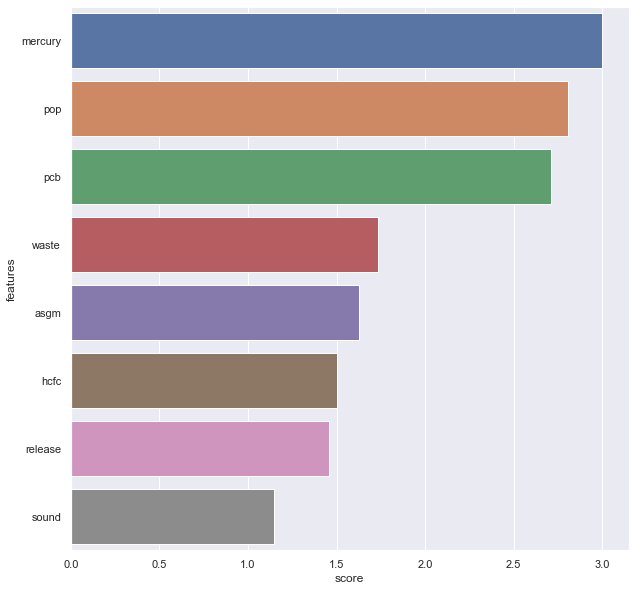

In [161]:
df_regressors = pd.DataFrame(columns = ["label", "features", "score"])


X_train, X_test, y_train, y_test = train_test_split(df['all_text_clean_spacy'],
                                                    df['chemicals_and_waste_programme'],
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True, 
                                                    stratify = df['chemicals_and_waste_programme'].values)


'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 2, max_df = 0.95)

vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

fnames = vect.get_feature_names()

clf = LogisticRegression(penalty='l2', solver = 'lbfgs', class_weight= 'balanced').fit(X_train, y_train)
print('')
print('Training accuracy:', clf.score(X_train, y_train).round(3))
print('Test accuracy:', clf.score(X_test, y_test).round(3))
y_hat = clf.predict(X_test)
print('f1 score:', f1_score(y_test, y_hat))
#top regressors 
#return top  regressors and convert to dataframe for visualisation:
df_lambda = tools.get_topwords(clf, vectorizer, n = 8, n_models = 1, show_idxmax = True)
keywords = df_lambda.Keywords.iloc[0]

for key in keywords:

    df_regressors = df_regressors.append({'label': 'persistent_organic_pollutants', "features":key}, ignore_index=True)
    df_regressors['features'] = df_regressors['features'].astype(str)
    df_regressors['features'] = df_regressors['features'].str.replace('(','')
    df_regressors['features'] = df_regressors['features'].str.replace(')','')
    df_regressors['features'] = df_regressors['features'].str.replace("'",'')               

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

df_regressors[['features','score']] = df_regressors['features'].str.split(',',expand=True)
df_regressors['score'] = df_regressors['score'].astype(float)    
plt.figure(figsize=(10,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_regressors)

In [28]:
vect

TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))

In [39]:
w = eli5.show_weights(clf, feature_names=fnames, top=5000)
result = pd.read_html(w.data)
result

[     Weight?         Feature
 0     +2.999         mercury
 1     +2.806             pop
 2     +2.709             pcb
 3     +1.732           waste
 4     +1.628            asgm
 ...      ...             ...
 4997  -0.619            area
 4998  -0.625  climate change
 4999  -0.663          change
 5000  -1.130         climate
 5001  -1.454          <BIAS>
 
 [5002 rows x 2 columns]]

In [163]:
input_string = input()
input_list = [input_string]
input_df = pd.DataFrame(input_list, columns =['all_text_clean_spacy'])
input_df['all_text_clean_spacy'] = input_df['all_text_clean_spacy'].apply(clean.spacy_clean)
clean_df = pd.Series(input_df['all_text_clean_spacy'])

Toxic chemicals are found in all ecosystems on Earth, including Antarctica and the most remote seas, affecting biodiversity, agricultural production, water quality, and human health. Over 100 million man-made chemicals and chemical formulations are used in every sector of the industrial economy. Many chemicals, such as persistent organic pollutants (POPs) and mercury, travel over large distances through air, water currents and in migratory species. Some POPs can remain in the human body for more than 50 years. Mercury, an element, is infinitely persistent.  When used improperly or disposed of unsafely, chemicals pose significant risks for both the environment and human health: scientists estimate that just about every person on the planet carries within their body a large number of chemical contaminants that have an unknown impact on their well-being.  Due to the global impact on human health and the environment some of these highly dangerous chemicals are controlled by international l

In [193]:
w = show_prediction(clf, vect.transform(clean_df), 
                highlight_spaces = True, 
                top=5000, 
                feature_names=fnames, 
                show_feature_values  = True)

result = pd.read_html(w.data)[0]
result = result[['Feature']]
top_5 = result.Feature.iloc[0:5].tolist()
top_5_10 = result.Feature.iloc[5:10].tolist()
last_5 = result.Feature.iloc[-5:].tolist()
top_5_10 = result.Feature.iloc[-10:].tolist()
top_5_10 = list(set(top_5_10) - set(last_5))

for i in top_5:
    green = "<div> <span class='highlight green'>"+i+"</div>"
    
green

"<div> <span class='highlight green'>waste</div>"

## WITH LSA

In [119]:
#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

vec = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

#Dimenionality reduction. Only using the 250 best features er category
svd = TruncatedSVD(n_components=250, 
                   n_iter=20, 
                   random_state=3)

lsa = make_pipeline(vec, svd)
clf = LogisticRegression(penalty='l2', solver = 'lbfgs', class_weight= 'balanced')

pipe = make_pipeline(lsa, clf)

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(df['all_text_clean_spacy'],
                                                    df['chemicals_and_waste_programme'],
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True, 
                                                    stratify = df['chemicals_and_waste_programme'].values)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

print('Test accuracy:', pipe.score(X_test, y_test).round(3))
y_hat = pipe.predict(X_test)
print('f1 score:', f1_score(y_test, y_hat))            

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

Test accuracy: 0.994
f1 score: 0.9565217391304348
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       161
           1       1.00      0.92      0.96        12

    accuracy                           0.99       173
   macro avg       1.00      0.96      0.98       173
weighted avg       0.99      0.99      0.99       173



In [159]:
pipe.predict_proba(clean_df)

array([[0.42495892, 0.57504108]])

In [158]:
import eli5
from eli5.lime import TextExplainer
te = TextExplainer(random_state=42)

te.fit(clean_df, pipe.predict_proba)
#te.show_prediction()

AttributeError: 'Series' object has no attribute 'toarray'

In [187]:
for i in top_5:
    green = "<div> <span class='highlight green'>"+i+"</div>"
    replace_green = (i, "", green)

In [194]:
top = [top_5, last_5]

[['chemical', 'mercury', 'pop', 'health', 'waste'],
 ['specie', 'ecosystem', 'water', 'change', '<BIAS>']]

In [200]:
for i in top[1]:
    print(i)

specie
ecosystem
water
change
<BIAS>
